<a href="https://colab.research.google.com/github/steveseguin/2DOF-PI-WebRTC-Camera/blob/master/Frequency_Response_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup: Install and Import Necessary Libraries
!pip install numpy scipy matplotlib

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from google.colab import files
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import re

def smooth_log_bands(freqs, response, min_freq=50, max_freq=15000, base=3, min_window=5, max_window=2001):
    # Define frequency bands logarithmically
    num_bands = int(np.log(max_freq / min_freq) / np.log(base)) + 1
    band_edges = [min_freq * (base ** i) for i in range(num_bands + 1)]
    band_edges[-1] = max_freq  # Ensure the last band goes up to max_freq

    smoothed_response = np.zeros_like(response)

    # Apply smoothing within each band
    for i in range(len(band_edges) - 1):
        # Find indices for this band
        band_indices = (freqs >= band_edges[i]) & (freqs < band_edges[i+1])
        if np.any(band_indices):
            # Determine window size for this band (linear scale within log bands)
            window_size = min_window + i * ((max_window - min_window) / num_bands)
            window_size = int(window_size) | 1  # Ensure window size is odd

            # Apply Savitzky-Golay filter to this band
            try:
                smoothed_band = savgol_filter(response[band_indices], window_size, 3)
                smoothed_response[band_indices] = smoothed_band
            except ValueError:
                # In case of unexpected error, fallback to original values for this band
                smoothed_response[band_indices] = response[band_indices]

    return smoothed_response

def process_filename(filename):
    # Remove added numbers in parentheses and file extension
    filename = re.sub(r"\(\d+\)", "", filename)  # Remove (1), (2), etc.
    filename = re.sub(r"\.\w+$", "", filename)  # Remove file extension
    return filename

# Function to Load Audio Files
def load_audio(filename):
    samplerate, data = wavfile.read(filename)
    if data.ndim > 1:
        data = data.mean(axis=1)  # Convert to mono if stereo
    return samplerate, data

# FFT Analysis Function
def fft_analysis(data, samplerate):
    fft_spectrum = rfft(data)
    freqs = rfftfreq(len(data), 1/samplerate)
    magnitude = np.abs(fft_spectrum)
    return freqs, magnitude

def load_calibration_file(filename):
    calibration_data = {}
    with open(filename, 'r') as file:
        next(file)  # Skip header line if there is one
        for line in file:
            parts = line.split()
            if len(parts) == 2:  # Ensure there are exactly 2 columns
                freq, correction = parts
                calibration_data[float(freq)] = float(correction)
    return calibration_data

def apply_calibration(freqs, magnitude, calibration_data, direction='compensate'):
    # Create an interpolator for the calibration data
    calibration_freqs = list(calibration_data.keys())
    calibration_corrections = [calibration_data[freq] for freq in calibration_freqs]
    interpolator = interp1d(calibration_freqs, calibration_corrections, bounds_error=False, fill_value="extrapolate")

    # Apply the calibration correction
    correction_factors = interpolator(freqs)
    if direction == 'compensate':
        corrected_magnitude = magnitude * 10**(-correction_factors/20)  # Compensate for deviations
    elif direction == 'enhance':
        corrected_magnitude = magnitude * 10**(correction_factors/20)  # Enhance deviations
    else:
        raise ValueError("Invalid direction specified. Use 'compensate' or 'enhance'.")

    return corrected_magnitude

def smooth_continuous_log_bands(freqs, response, min_freq=50, max_freq=15000, base=10, min_window=5, max_window=2001):
    # Calculate the continuous logarithmic scale factor for each frequency
    log_scale_factor = np.log(freqs / min_freq) / np.log(max_freq / min_freq)

    # Interpolate window sizes across the frequency range based on the logarithmic scale factor
    window_sizes = min_window + (log_scale_factor * (max_window - min_window)).astype(int)
    # Ensure window sizes are odd
    window_sizes = (window_sizes // 2) * 2 + 1

    smoothed_response = np.copy(response)

    # Apply Savitzky-Golay filter with continuously varying window size
    for i, window_size in enumerate(window_sizes):
        if window_size > 3:  # Minimum window size to apply Savitzky-Golay
            # Limit window size near the edges of the array
            start_index = max(i - window_size // 2, 0)
            end_index = min(i + window_size // 2 + 1, len(freqs))
            actual_window_size = end_index - start_index
            if actual_window_size > 3:
                try:
                    # Apply smoothing only within the window around the current point
                    smoothed_segment = savgol_filter(response[start_index:end_index], actual_window_size, 3)
                    # Update the smoothed response at the current point
                    smoothed_response[i] = smoothed_segment[window_size // 2]
                except ValueError:
                    # In case of unexpected error, leave the original value
                    pass

    return smoothed_response

In [ ]:
# Upload Audio Files
print("Upload your reference audio file (with a known flat-response microphone recording):")
uploaded_ref = files.upload()
reference_filename = list(uploaded_ref.keys())[0]
samplerate_ref, data_ref_unclipped = load_audio(reference_filename)
reference_filename_processed = process_filename(reference_filename)
data_ref = None # clear
uploaded_calibration = None # clear

Upload your reference audio file (with a known flat-response microphone recording):


Saving fduce.wav to fduce (4).wav


In [ ]:
print("Upload your test audio file (the microphone you want to test):")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
samplerate_test, data_test_unclipped = load_audio(test_filename)
test_filename_processed = process_filename(test_filename)
data_test = None # clear

Upload your test audio file (the microphone you want to test):


Saving tank3.wav to tank3 (3).wav


In [ ]:
# Trim to match lengths
min_length = min(len(data_ref_unclipped), len(data_test_unclipped))
data_ref = data_ref_unclipped[:min_length]
data_test = data_test_unclipped[:min_length]

# Calculate the Frequency Response
freqs_ref, magnitude_ref = fft_analysis(data_ref, samplerate_ref)
freqs_test, magnitude_test = fft_analysis(data_test, samplerate_test)

In [ ]:
# This step is only if you have a calibration file
print("Upload your reference mic's calibration file (if available):")
uploaded_calibration = files.upload()

calibration_filename = list(uploaded_calibration.keys())[0]
calibration_data = load_calibration_file(calibration_filename)

# Example usage with FFT results (freqs_ref and magnitude_ref)
freqs_ref, magnitude_ref = fft_analysis(data_ref, samplerate_ref) #just in case
magnitude_ref = apply_calibration(freqs_ref, magnitude_ref, calibration_data)

Upload your reference mic's calibration file (if available):


Saving 28821.txt to 28821.txt


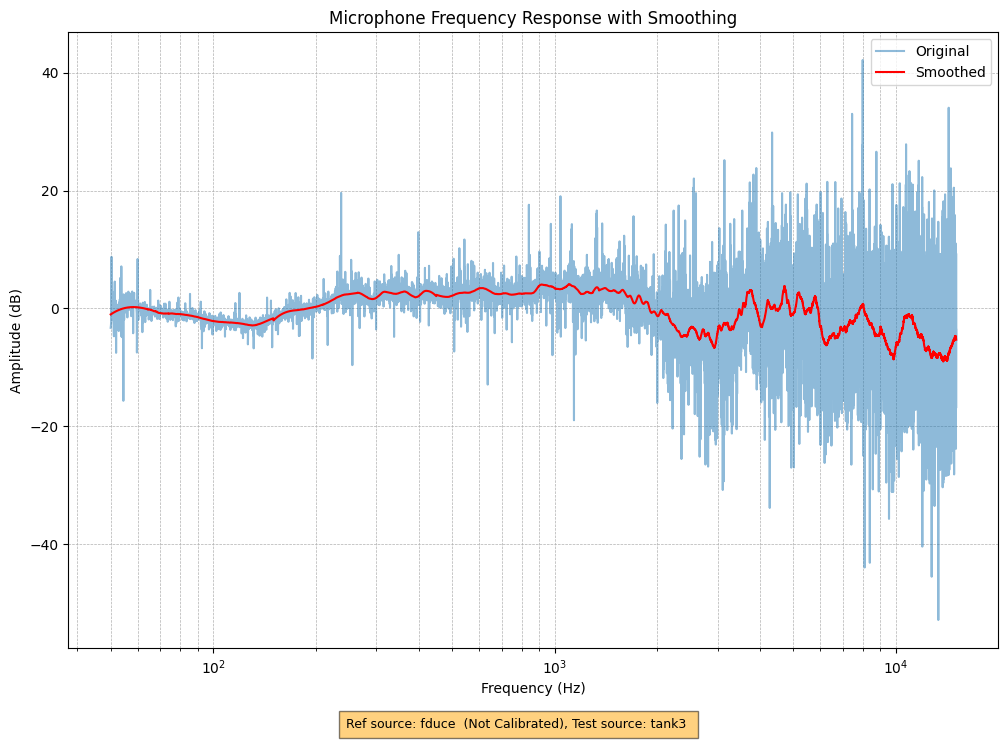

In [ ]:
frequency_response = 20 * np.log10(magnitude_test / magnitude_ref)

# Filter the data to include frequencies from 50 Hz up to 15 kHz
lower_limit_freq = 50  # Upper frequency limit in Hz
upper_limit_freq = 15000  # Upper frequency limit in Hz
valid_indices = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)
filtered_freqs = freqs_ref[valid_indices]
filtered_response = frequency_response[valid_indices]

smoothed_filtered_response = smooth_log_bands(
    freqs=filtered_freqs,
    response=filtered_response,
    min_freq=50,
    max_freq=15000,
    base=3,
    min_window=301,
    max_window=2001
)

# Plot the Filtered and Smoothed Frequency Response Curves
plt.figure(figsize=(12, 8))

# Determine if a calibration file was uploaded
calibration_status = "Calibrated" if uploaded_calibration else "Not Calibrated"

# Original Filtered Curve
plt.plot(filtered_freqs, filtered_response, label='Original', alpha=0.5)

# Smoothed Filtered Curve
plt.plot(filtered_freqs, smoothed_filtered_response, label='Smoothed', color='red')

# Metadata Annotation
metadata_str = f"Ref source: {reference_filename_processed} ({calibration_status}), Test source: {test_filename_processed}"
plt.figtext(0.5, 0.01, metadata_str, ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.xscale('log')
plt.title('Microphone Frequency Response with Smoothing')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()
